### Test of regularization with error network

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.core import Lambda
from keras.initializers import Constant
from keras.regularizers import l1, l2
from experiment_constant import *
from helpers import *
from functools import partial

Using TensorFlow backend.


In [2]:
x_train, y_train, x_test, y_test = get_mnist()

In [3]:
# max per layer variable
C1 = K.variable(value = np.zeros((11, 1)))
C2 = K.variable(value = np.zeros((12, 1)))
C3 = K.variable(value = np.zeros((13, 1)))
C = [C1, C2, C3]

In [4]:
# first layer of error network
errors = {0: K.variable(value = np.zeros((11, 1)))}

In [5]:
# defining the network
model = Sequential()
model.add(Dense(11, kernel_initializer = 'random_normal', bias_initializer = 'random_normal', activation = lambda x : K.relu(1.11 * x), input_shape = (784,)))
model.add(Dense(12, kernel_initializer = 'random_normal', bias_initializer = 'random_normal', activation = lambda x : K.relu(1.11 * x), kernel_regularizer = get_kernel_reg_v2(1, errors, False, C1, 0.1, 1.11, 0)))
model.add(Dense(13, kernel_initializer = 'random_normal', bias_initializer = 'random_normal', activation = lambda x : K.relu(1.11 * x), kernel_regularizer = get_kernel_reg_v2(2, errors, False, C2, 0.2, 1.11, 0)))
model.add(Dense(10, kernel_initializer = 'random_normal', bias_initializer = 'random_normal', activation = 'linear', kernel_regularizer = get_kernel_reg_v2(3, errors, True, C3, 0.3, 1.11, 0.01)))

Error is_last = 0 1 = W(pC + K(1-p) DeltaOld) p = 0.100000 C = <tf.Variable 'Variable:0' shape=(11, 1) dtype=float32_ref> K = 1.110000 DeltaOld = <tf.Variable 'Variable_3:0' shape=(11, 1) dtype=float32_ref> W = Tensor("dense_2/weight_regularizer/Abs:0", shape=(11, 12), dtype=float32)
Error is_last = 0 2 = W(pC + K(1-p) DeltaOld) p = 0.200000 C = <tf.Variable 'Variable_1:0' shape=(12, 1) dtype=float32_ref> K = 1.110000 DeltaOld = Tensor("dense_2/weight_regularizer/MatMul:0", shape=(12, 1), dtype=float32) W = Tensor("dense_3/weight_regularizer/Abs:0", shape=(12, 13), dtype=float32)
Error is_last = 1 3 = W(pC + K(1-p) DeltaOld) p = 0.300000 C = <tf.Variable 'Variable_2:0' shape=(13, 1) dtype=float32_ref> K = 1.110000 DeltaOld = Tensor("dense_3/weight_regularizer/MatMul:0", shape=(13, 1), dtype=float32) W = Tensor("dense_4/weight_regularizer/Abs:0", shape=(13, 10), dtype=float32)


In [6]:
# calculating mean per neuron bound
inp = model.input
outputs = [K.mean(K.abs(layer.output), axis = 0) for layer in model.layers]
mean_per_neuron = lambda x : (K.function([inp, K.learning_phase()], outputs))([x, 1])

In [7]:
# calculating delta network output
delta_network = lambda : (K.function([K.learning_phase()], [K.mean(errors[3])]))([1])[0]

In [8]:
# compiling the model
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy', 'mean_squared_error'])

In [9]:
# training the model
history = []
deltas = []
for i in range(100):
    history += [model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 1, batch_size = 30000)]
    for C_, v in zip(C, mean_per_neuron(x_train)):
        K.set_value(C_, v.reshape(-1, 1))
    deltas += [delta_network()]

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 1s 9us/step - loss: 0.1290 - acc: 0.0851 - mean_squared_error: 0.1290 - val_loss: 0.1050 - val_acc: 0.0995 - val_mean_squared_error: 0.1050
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 4us/step - loss: 0.1076 - acc: 0.1066 - mean_squared_error: 0.1031 - val_loss: 0.1028 - val_acc: 0.1210 - val_mean_squared_error: 0.0985
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 4us/step - loss: 0.1021 - acc: 0.1232 - mean_squared_error: 0.0976 - val_loss: 0.0989 - val_acc: 0.1362 - val_mean_squared_error: 0.0946
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 4us/step - loss: 0.0987 - acc: 0.1425 - mean_squared_error: 0.0940 - val_loss: 0.0963 - val_acc: 0.1664 - val_mean_squared_error: 0.0918
Train on 600

60000/60000 [==============================] - 0s 4us/step - loss: 0.0690 - acc: 0.4958 - mean_squared_error: 0.0644 - val_loss: 0.0682 - val_acc: 0.5156 - val_mean_squared_error: 0.0636
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 4us/step - loss: 0.0684 - acc: 0.4965 - mean_squared_error: 0.0637 - val_loss: 0.0676 - val_acc: 0.5129 - val_mean_squared_error: 0.0630
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 4us/step - loss: 0.0678 - acc: 0.4978 - mean_squared_error: 0.0631 - val_loss: 0.0667 - val_acc: 0.5173 - val_mean_squared_error: 0.0621
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 4us/step - loss: 0.0670 - acc: 0.5038 - mean_squared_error: 0.0623 - val_loss: 0.0659 - val_acc: 0.5235 - val_mean_squared_error: 0.0613
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 

60000/60000 [==============================] - 0s 4us/step - loss: 0.0570 - acc: 0.5536 - mean_squared_error: 0.0533 - val_loss: 0.0558 - val_acc: 0.5749 - val_mean_squared_error: 0.0521
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 4us/step - loss: 0.0563 - acc: 0.5581 - mean_squared_error: 0.0527 - val_loss: 0.0550 - val_acc: 0.5781 - val_mean_squared_error: 0.0513
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 4us/step - loss: 0.0557 - acc: 0.5607 - mean_squared_error: 0.0520 - val_loss: 0.0544 - val_acc: 0.5809 - val_mean_squared_error: 0.0508
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 4us/step - loss: 0.0554 - acc: 0.5620 - mean_squared_error: 0.0517 - val_loss: 0.0543 - val_acc: 0.5840 - val_mean_squared_error: 0.0506
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 

60000/60000 [==============================] - 0s 4us/step - loss: 0.0501 - acc: 0.6695 - mean_squared_error: 0.0467 - val_loss: 0.0487 - val_acc: 0.7036 - val_mean_squared_error: 0.0453


In [16]:
# obtaining accuracy
acc = [x for h in history for x in h.history['acc']]
val_acc = [x for h in history for x in h.history['val_acc']]

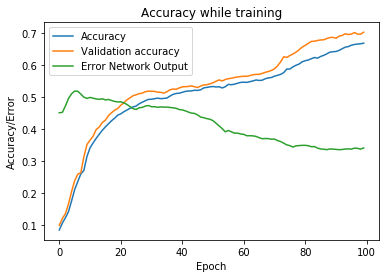

In [17]:
# plotting the training data
plt.figure()
plt.title('Accuracy while training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Error')
plt.plot(acc, label = 'Accuracy')
plt.plot(val_acc, label = 'Validation accuracy')
plt.plot(deltas, label = 'Error Network Output')
plt.legend()
plt.show()

In [12]:
# obtaining the delta network bound (TF)
for C_, v in zip(C, mean_per_neuron(x_train)):
    K.set_value(C_, v.reshape(-1, 1))
delta_network()

0.3416772

In [13]:
# obtaining weights
W = model.get_weights()[::2]
B = model.get_weights()[1::2]

In [14]:
# Creating a constant experiment
experiment = ConstantExperiment([784, 11, 12, 13, 10], [0.1, 0.2, 0.3], 1.11, W, B, 'relu')

In [18]:
# Checking that C was calculated correctly
experiment.create_supplementary_functions()
experiment.update_C(x_train)
assert all([np.allclose(K.get_value(C1).flatten(), C2) for C1, C2 in zip(C, experiment.C)]), "C calculation"

In [19]:
# Calculating mean error bound (numpy)
np.mean(experiment.get_mean_error_v2())

0.3416771713154462

In [20]:
# Checking that numpy and TF implementations coincide
assert all([np.allclose(K.get_value(errors[i]).flatten(), delta) for i, delta in zip(range(0, 4), experiment.EDeltaArr)]), "Bound"